# 02450 Project


In [232]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import xlrd
import scipy
from scipy.linalg import svd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


Load data of usa_wood_data_formatted.csv

In [233]:
data = pd.read_csv('C:/Users/ongji/OneDrive/Documents/DTU/02450 Introduction to Machine Learning and Data Mining/usa_wood_data_formatted.csv')
# print(data.head())  

Clean data by removing rows with missing values

In [234]:
data_cleaned = data.dropna()
print(data_cleaned.isnull().sum()) # 0 means data is clean

common_species_name                   0
genus                                 0
species                               0
scientific_name                       0
classification                        0
moisture_content                      0
specific_gravity                      0
modulus_of_rupture                    0
modulus_of_elasticity                 0
work_to_maximum_load                  0
impact_bending                        0
compression_parallel_to_grain         0
compression_perpendicular_to_grain    0
shear_parallel_to_grain               0
tension_perpendicular_to_grain        0
side_hardness                         0
dtype: int64


<span style="color:lightblue">**Visualize the relationship between 2 selected attributes of the usa_wood dataset, color-coded by class labels.**<span>

Class label used: genus
Attributes used: specific_gravity (6) and modulus_of_rupture (7)

All attributes and their corresponding numbers are printed.

<span style="color:red">**NOTE: Clarify on moisture_content. Remove Green**<span>



0 common_species_name
1 genus
2 species
3 scientific_name
4 classification
5 moisture_content
6 specific_gravity
7 modulus_of_rupture
8 modulus_of_elasticity
9 work_to_maximum_load
10 impact_bending
11 compression_parallel_to_grain
12 compression_perpendicular_to_grain
13 shear_parallel_to_grain
14 tension_perpendicular_to_grain
15 side_hardness


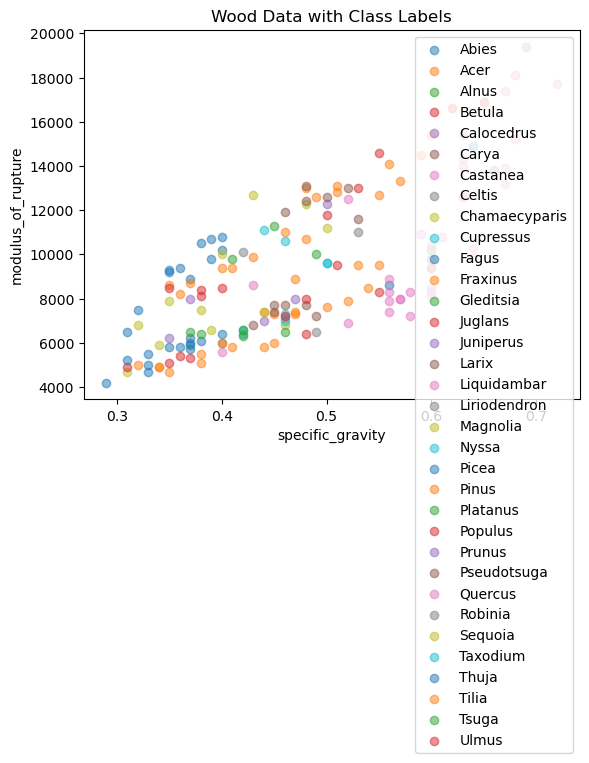

In [235]:
# Extract attribute names (1st row, column 0 to 16)
attributeNames = data_cleaned.columns[:16]
for i in range(len(attributeNames)):
    print(i, attributeNames[i])

# Extract class names to python list,
# then encode with integers (dict)
classLabels = data_cleaned['genus'].values
classNames = sorted(set(classLabels))
classDict = {className: index for index, className in enumerate(classNames)}
y = np.array([classDict[label] for label in classLabels])

# Preallocate memory, then extract excel data to matrix X
X = data_cleaned.iloc[:,0:16].values

# Compute values of N, M and C.
N = len(y)
M = len(attributeNames)
C = len(classNames)


# Data attributes to be plotted
i = 6
j = 7


# Plotting the wood data
for c in range(C):
    class_mask = y == c
    plt.scatter(X[class_mask, i], X[class_mask, j], label=classNames[c], alpha=0.5)
plt.xlabel(attributeNames[i])
plt.ylabel(attributeNames[j])
plt.title("Wood Data with Class Labels")
plt.legend()
plt.show()



# PCA

<span style="color:lightblue">**Perform PCA on the cleaned and scaled data X**<span>

From the plot, more than 90% of the data is in the first 3 components.


Singular values: [35.57435636 15.10517883  8.94378048  5.98343891  5.37578728  3.25583802
  2.76382469  2.74517981  2.06312371  1.25507085]
Variance explained: [0.75780529 0.1366266  0.04789893 0.02143805 0.01730484 0.00634759
 0.00457409 0.00451258 0.00254879 0.00094324]
Cumulative variance explained: [0.75780529 0.89443189 0.94233082 0.96376887 0.98107371 0.9874213
 0.99199539 0.99650797 0.99905676 1.        ]


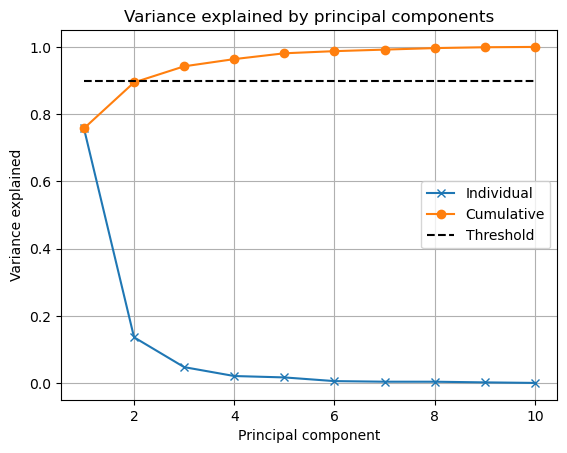

In [236]:
# Filter out numerical values
X_num = data_cleaned.iloc[:,6:16].values # change this once green is removed

# Scale and substract mean from data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
Y = X_scaled - np.ones((N, 1)) * X_scaled.mean(axis=0)

# PCA by computing SVD of Y
U, S, Vh = svd(Y, full_matrices=False)

# Compute variance explained by principal components
rho = (S * S) / (S * S).sum()

print("Singular values:", S)
print("Variance explained:", rho)
print("Cumulative variance explained:", np.cumsum(rho))

threshold = 0.9

# Plot variance explained
plt.figure()
plt.plot(range(1, len(rho) + 1), rho, "x-")
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
plt.plot([1, len(rho)], [threshold, threshold], "k--")
plt.title("Variance explained by principal components")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()
plt.show()



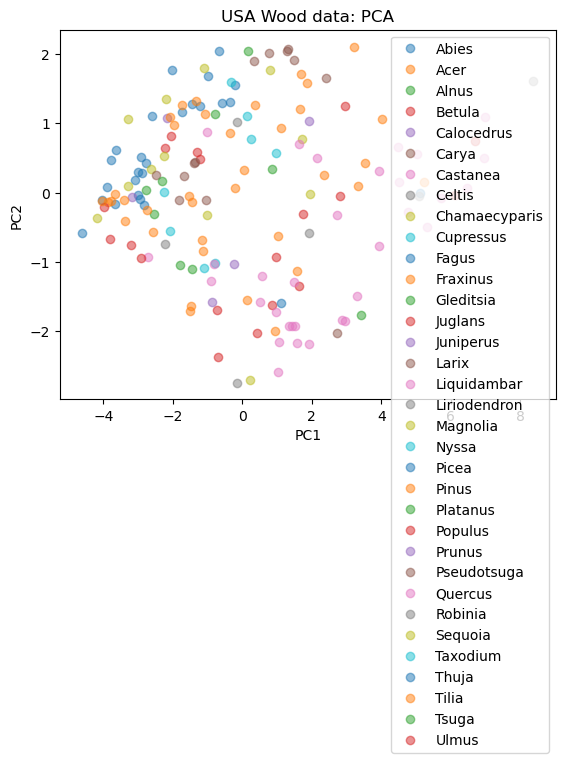

In [237]:
# scipy.linalg.svd returns "Vh", which is the Hermitian (transpose)
# of the vector V. So, for us to obtain the correct V, we transpose:
V = Vh.T

# Project the centered data onto principal component space
Z = Y @ V

# Indices of the principal components to be plotted
i = 0 # This is now specific_gravity
j = 1 # This is now modulus_of_rupture

# Plot PCA of the data
f = plt.figure()
plt.title("USA Wood data: PCA")
# Z = array(Z)
for c in range(C):
    # select indices belonging to class c:
    class_mask = y == c
    plt.plot(Z[class_mask, i], Z[class_mask, j], "o", alpha=0.5)
plt.legend(classNames)
plt.xlabel("PC{0}".format(i + 1))
plt.ylabel("PC{0}".format(j + 1))

# Output result to screen
plt.show()



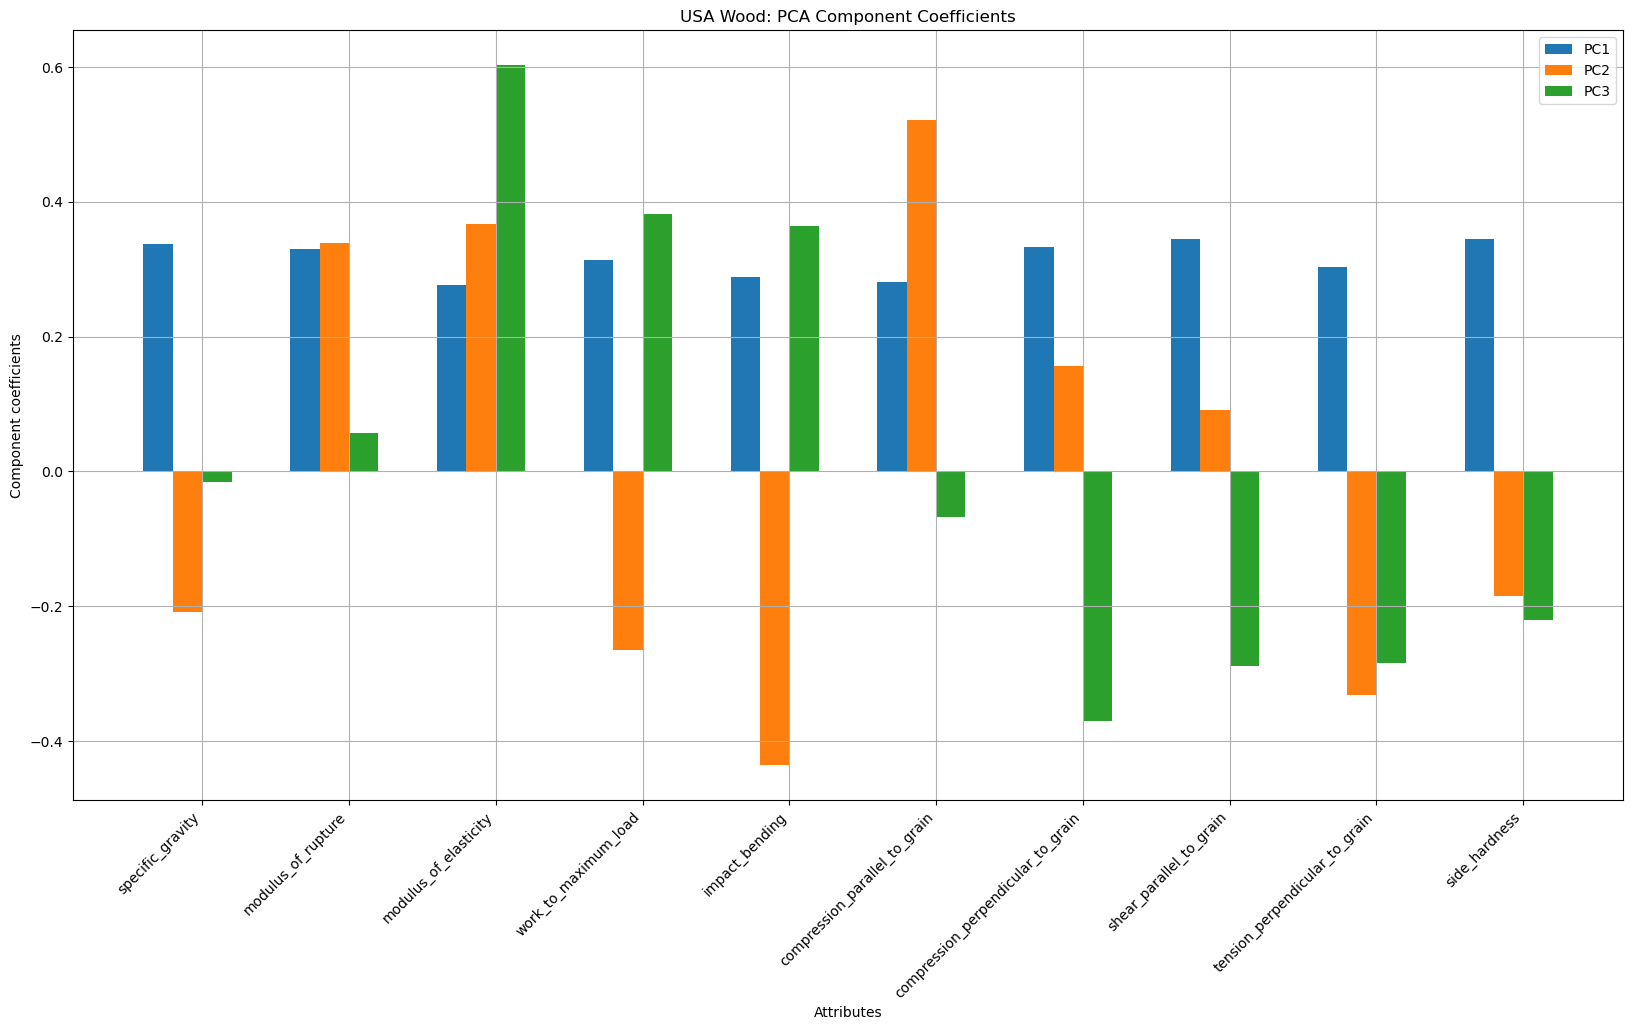

In [238]:
N, M = X_scaled.shape # Number of samples and attributes 
attributeNames_num = data_cleaned.columns[6:16] # Numerical attributes only

# Plot coefficients of the first 3 PCs
pcs = [0, 1, 2]
legendStrs = ["PC" + str(e + 1) for e in pcs]
c = ["r", "g", "b"]
bw = 0.2
r = np.arange(1, M + 1)

plt.figure(figsize=(20, 10)) 

for i in pcs:
    plt.bar(r + i * bw, V[:, i], width=bw)

plt.xticks(r + bw * len(pcs) / 2, attributeNames_num, rotation=45, ha="right")
#plt.xticks(r + bw, attributeNames_num)
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend(legendStrs)
plt.grid()
plt.title("USA Wood: PCA Component Coefficients")
plt.show()



<span style="color: lightblue">**More Detaiied analysis using PCA (Taken from ex2_1_6.py)**</span>

Find out how different data standardization methods (data using zero mean & data using both zero mean and unit variance) affect PCA results by visualizing the projections onto PCs, the coefficients of attributes in the PC space, and the variance explained by PCs. 


[1.01623100e-01 3.18897274e+03 3.04792937e-01 3.81354262e+00
 1.09336070e+01 1.79978525e+03 3.01916571e+02 3.94481438e+02
 2.19688431e+02 3.55038782e+02]


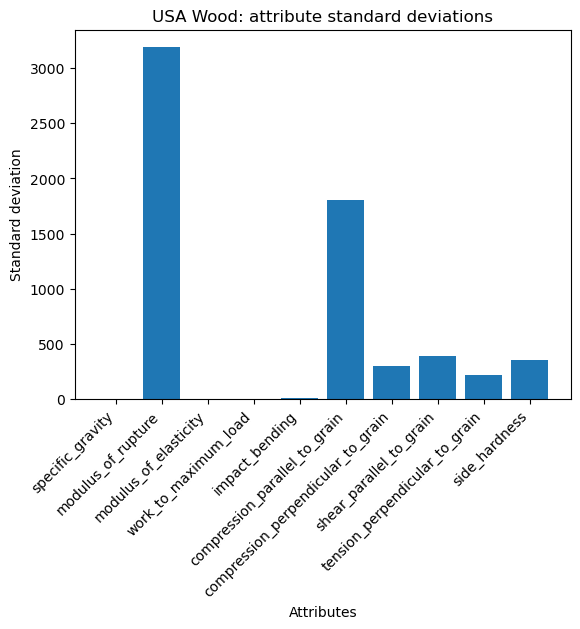

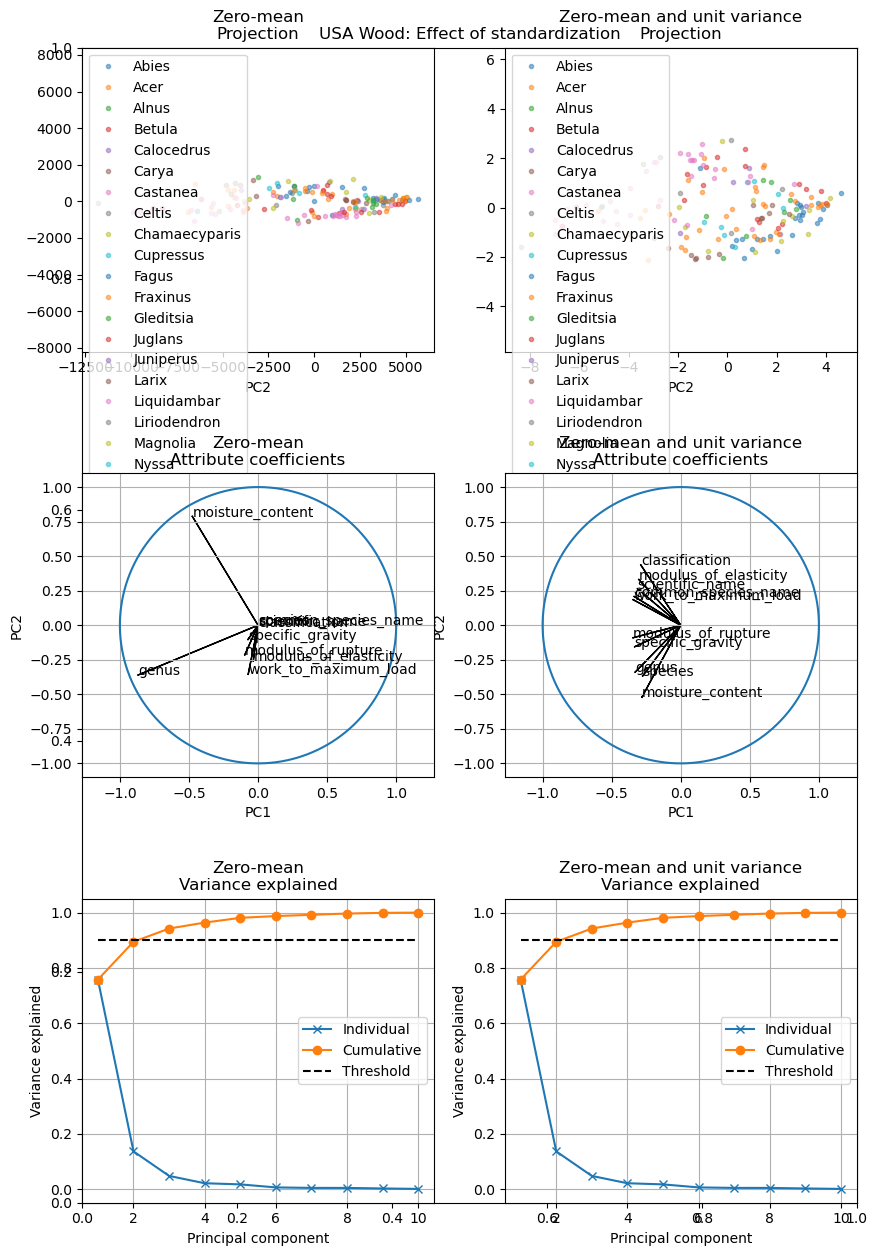

In [239]:
r = np.arange(1, X_num.shape[1] + 1)
plt.bar(r, np.std(X_num, 0))
plt.xticks(r, attributeNames_num, rotation=45, ha="right")
print(np.std(X_num, 0))
plt.ylabel("Standard deviation")
plt.xlabel("Attributes")
plt.title("USA Wood: attribute standard deviations")


# Subtract the mean from the data
Y1 = X_num - np.ones((N, 1)) * X_num.mean(0)

# Subtract the mean from the data and divide by the attribute standard
# deviation to obtain a standardized dataset:
Y2 = X_num - np.ones((N, 1)) * X_num.mean(0)
Y2 = Y2 * (1 / np.std(Y2, 0)) 

# Store the two in a cell, so we can just loop over them:
Ys = [Y1, Y2]
titles = ["Zero-mean", "Zero-mean and unit variance"]
threshold = 0.9

# Choose two PCs to plot (the projection)
i = 0
j = 1

# Make the plot
plt.figure(figsize=(10, 15))
plt.subplots_adjust(hspace=0.4)
plt.title("USA Wood: Effect of standardization")
nrows = 3
ncols = 2
for k in range(2):
    # Obtain the PCA solution by calculate the SVD of either Y1 or Y2
    U, S, Vh = svd(Ys[k], full_matrices=False)
    V = Vh.T  # For the direction of V to fit the convention in the course we transpose
    # For visualization purposes, we flip the directionality of the
    # principal directions such that the directions match for Y1 and Y2.
    if k == 1:
        V = -V
        U = -U

    # Compute the projection onto the principal components
    Z = U * S

    # Plot projection
    plt.subplot(nrows, ncols, 1 + k)
    C = len(classNames)
    for c in range(C):
        plt.plot(Z[y == c, i], Z[y == c, j], ".", alpha=0.5)
    plt.xlabel("PC" + str(i + 1))
    plt.xlabel("PC" + str(j + 1))
    plt.title(titles[k] + "\n" + "Projection")
    plt.legend(classNames)
    plt.axis("equal")

    # Plot attribute coefficients in principal component space
    plt.subplot(nrows, ncols, 3 + k)
    for att in range(V.shape[1]):
        plt.arrow(0, 0, V[att, i], V[att, j])
        plt.text(V[att, i], V[att, j], attributeNames[att])
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.xlabel("PC" + str(i + 1))
    plt.ylabel("PC" + str(j + 1))
    plt.grid()
    # Add a unit circle
    plt.plot(
        np.cos(np.arange(0, 2 * np.pi, 0.01)), np.sin(np.arange(0, 2 * np.pi, 0.01))
    )
    plt.title(titles[k] + "\n" + "Attribute coefficients")
    plt.axis("equal")

    # Plot cumulative variance explained
    plt.subplot(nrows, ncols, 5 + k)
    plt.plot(range(1, len(rho) + 1), rho, "x-")
    plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
    plt.plot([1, len(rho)], [threshold, threshold], "k--")
    plt.title("Variance explained by principal components")
    plt.xlabel("Principal component")
    plt.ylabel("Variance explained")
    plt.legend(["Individual", "Cumulative", "Threshold"])
    plt.grid()
    plt.title(titles[k] + "\n" + "Variance explained")

plt.show()
